# Defect Detection and Segmentation
Üretim aşamasında oluşan hataları (defectlerin) tespit etmek için derin öğrenme modellerini kullanabiliriz. Bu yazıda çelik üretimi yapılan bir fabrikada çıkan ürünlerden hatalı olanların tespit detect edilmesi ve bu hatanın yerini localization ile tespit etmeye çalışalım. 

## Classification Modeli 
Bu işlemi yapmak için 2 model kullanacağız. Bunlardan ilki sınıflandırma işlemini yapacak modelimiz olacak. Bu model için input olarak defect ve non-defect dataları kullanacağız. Çıktı olarakda daha sonra gönderilen datada defect var mı bunu tespit etmesini bekleyeceğiz. Buradan aldığımız defect olan çıktı. Hatanın yerinin belirlenmesi için segmentasyon modelimiz olan Unet modeline gidecek. 

## Image Segmentation Nedir? 
Image Segmantation, gönderilen resimlerden piksel seviyesinde anlam çıkarmaktır. Genellikle recognition ve localization işlemlerinde kullanılır. Eğitilen modele bir resim gönderildiğinde o piksel değerinde beklenen datanın olup olmadığını maskeleme ile göstermesidir. 

## Unet segmentation modeli 
Unet modeli input olarak bir resim alır bu resim üzerinde encoding işlemi uygulanır.Resim boyutları Max Pooling ile küçültülür ve bir bottlenecke gönderilir.Burada anlam çıkartılmış olan data decoder modele girer ve upsampling işlemi uygulanır. Biz bu örnekte ResUnet mimarisini kullanacağız

In [36]:
import pandas as pd
import glob
import os
from PIL import Image
import numpy as np 
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [15]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\bagat\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Maskeleme nedir? 
Maskeleme işleminde bir resmin üzerindeki her piksel bir sınıfa aittir. Image segmentation modeli tarafından üretilen data maske datasıdır. Maske piksel değerleri ve bu piksel değerlerinin konumları ile oluşturulur. 
Maskeyi tek bir satır olarak gösterebiliriz. Örneğin elimizde (2,2) bir maske varsa [[255,0],[0,255]] bunu [255,0,0,255] şeklinde gösterebiliriz. 

## Run Length Encodeng nedir? 
Maskenin boyutunu küçülmek için kullanırız. Maskenin boyutu orjinal resmin boyutunda olması gerekir. Bu çok fazla yer kaplar. RLE ile maske verisini piksel değerini ve o pikselin kaç kere geçtiğini bir sayıda tutar. Örneğin: WWWWBBWWWWWWWWWWBBBWWWWWWWWWWWWWWWWWWWWWWWWWBBBBBBBWWWWW piksel değerleri 4W2B10W3B25W7B5W(Run Length Encoding) şeklinde store edilebilir.  video : https://www.youtube.com/watch?v=Yl50cJScObI

In [16]:
H = 256
W = 1600
# Buraya eğitim için kullanılacak resim datasının yolunu verelim. 
DATA_PATH = "train_images"

## Verilerin Okuması
train.csv içerisinde hata bulunan resimlerin aşağıdaki bilgileri bulunmaktadır.  
ImageId : Resmin adı   
ClassId : Defectin sınıfı   
EncodedPixels : Defecti göstermek için kullanağımız maske rle şeklinde    

train_images klasörü içerisinde bulunan resimlerin dosya yollarını glob kütüphanesi ile okuyup all_images_path içerisinde tutuyoruz.

In [17]:
defect_class_mask_df = pd.read_csv("train.csv")
defect_class_mask_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [18]:
all_images_path = glob.glob(f"{DATA_PATH}/*.jpg")

Defect olan resimlere 1 etiketi defect olmayan resimlere 0 etiketi verdik. Bunların bir dict içerisinde tutup daha sonra bunu bir dataframe'e çevirelim.


In [19]:
all_images_dict = {}
for img_path in all_images_path:
    img_name = img_path.split("\\")[-1]
    if img_name in defect_class_mask_df["ImageId"].values:
        all_images_dict[f"{img_name}"] = 1
    else :
        all_images_dict[f"{img_name}"] = 0
        

In [20]:
all_images_df = pd.DataFrame(all_images_dict.items(),columns=["ImageId","label"])
all_images_df.head()

,ImageId,label
0,0002cc93b.jpg,1
1,00031f466.jpg,0
2,000418bfc.jpg,0
3,000789191.jpg,0
4,0007a71bf.jpg,1


## Görselleştirme
Elimizde bulunan resimler hakkında daha ayrıntılı bilgiler elde etmek için veri görselleştirme işlemleri yapabiliriz.   
Defect ve non defect sınıflarından kaçar veri olduğunu value_counts metodu ile görebiliriz. Ayrıca count plot ile defect olan verilerden hangi tip defecten ne kadar var görebiliriz.

In [21]:
all_images_df["label"].value_counts()

1    6666
0    5902
Name: label, dtype: int64

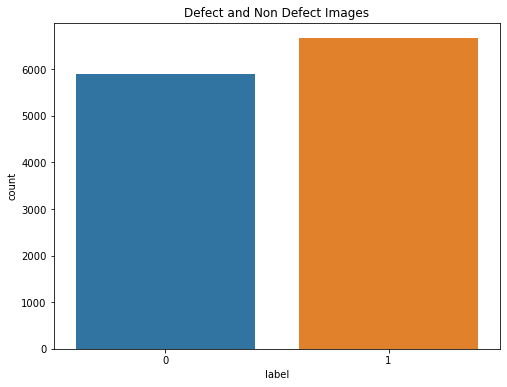

In [22]:
plt.figure(figsize=(8,6))
sns.countplot(x = "label",data=all_images_df)
plt.title("Defect and Non Defect Images")
plt.show()

In [23]:
defect_class_mask_df["mask"] = 1

4 çeşit defect bulunuyor. En çok bulunan defect tipi class id si 3 olan defectler.

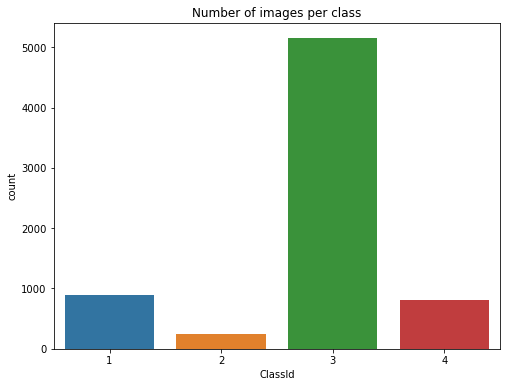

In [24]:
plt.figure(figsize=(8,6))
sns.countplot(x ="ClassId",data=defect_class_mask_df)
plt.title("Number of images per class")
plt.show()

Bir imagede birden fazla defect olabilir. Image id ye göre gruplayı her bir imagede kaç defect var kontrol edelim .  
6239 image de 1 çeşit defect   
425 imagde 2 çeşit defect   
2 imagede de 3 çeşit defect bulunuyor.  

In [25]:
defect_type = defect_class_mask_df.groupby(["ImageId"])["mask"].sum()
defect_type.value_counts()

1    6239
2     425
3       2
Name: mask, dtype: int64

Elimizde bulunan resimleri inceleyelim. Bazı resimerde bulunan hatalar hemen dikkatinizi çekmişir.

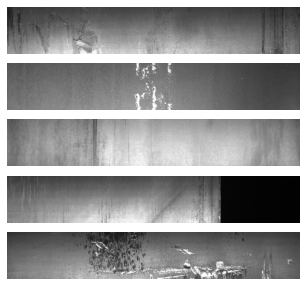

In [26]:
fig,axs = plt.subplots(5,1,figsize=(10,5))
for i in range(5):
    idx = np.random.randint(0,len(all_images_path))
    image = Image.open(all_images_path[idx])
    axs[i].imshow(image)
    axs[i].axis("off")


## RLE2MASK ve MASK2RLE
Dataframede buluanan EncodedPixels sütununda rle formatında maske verileri bulunuyor. Bu maske verileri alarak rle2mask ile maskeye çevriliyor. Aynı şekilde mask2rle ile de maske resimi rle formatına çevrilebilir.
https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

In [27]:
def rle2mask(rle, height, width):
    #creating a one dimentional array containing 0's of length obtained by multiplying height and width of the image
    mask = np.zeros(height*width).astype(np.uint8)

    #spliting the rle based on space , try running the rle.split() on separate cell to see how the values are separated based on space
    rle = rle.split()

    #selecting every second value in the list like obtaining values corresponding to indexes 0,2,4,....
    start = rle[0::2]

    #selecting every second value in the list like obtaining values corresponding to indexes 1,3,5,....
    length = rle[1::2]

    '''
    For example if rle value looks like this '4954 7 5800 20', in such a case elements belonging to even index like 4954, 5800 
    are taken as start point and the values belong to odd index likr 7,20 are the length. So we need to add length to the respective
    start pixels like 4954+7 and 5800+20, to the ending point. Now, we need to  apply mask '1' in pixles from 4954 to 4961 and 5800 to 5820.
    '''

    for i in range(len(start)):
        mask[int(start[i]):(int(start[i])+int(length[i]))] = 1

    #Now the shape of the mask is in one dimension, we need to convert the mask to the same dimension as the image, initally using reshape and followed by Transpose
    img = mask.reshape(width, height)
    img = img.T

    return img

def mask2rle(mask):

    #We do the reverse of what we did in the above function, initially apply Transpose to the mask image and then flatten to one dimension
    pixels = mask.T.flatten()

    #Here, we add extra values at front and end , this would help in finding the correct length of pixels that have been masked
    pixels = np.concatenate([[0], pixels, [0]])

    '''
    Here, consider a array which is like [0,0,1,1,1,0], we added two values at the first and last of the array, now the array looks like
    [0,0,0,1,1,1,0,0]. After that, we check whether pixels[1:] != pixels[:-1], (i.e.)[0,0,1,1,1,0,0] != [0,0,0,1,1,1,0]. As you can see, if we
    compared these two we would get something like[False,False,True,False,False,True,False]. Then,using np.where, we will get indexes
    corresponding to True, in this case, 2 and 5
    '''
    rle = np.where(pixels[1:] != pixels[:-1])[0]

    #here we subtract values in even index in the obtained list(i.e) [2,5], from the odd index, (i.e.)5-2 = 3, Now the list would look like [2, 3]
    rle[1::2] -= rle[0::2]

    #finally join to rle format, in this case it would look like ('2 3')
    return ' '.join(str(x) for x in rle)

### Defectlerin maskelerine bakalım 
rle2mask metodu ile encoded pixels değerlerinden bir maske elde ediyoruz. Bu elde ettiğimiz maskeyi kullanarak original imagede maskenin örtüştüğü bölgelerde yeşil ile defect bölgesini işaretliyoruz

In [31]:
image_index = np.random.randint(0,len(defect_class_mask_df))
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index],H,W)

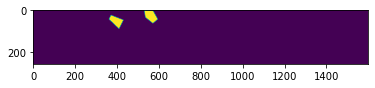

In [32]:
plt.imshow(mask)

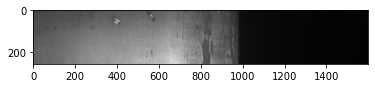

In [33]:
img = np.array(Image.open(os.path.join(DATA_PATH,defect_class_mask_df.iloc[image_index]["ImageId"])))
plt.imshow(img)

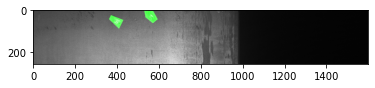

In [34]:
img[mask==1,1] =255 # Maske olan yerleri yeşil ile gösteriyoruz
plt.imshow(img)

Elimizde bulunan hataları resimlerin bir kaçını maskelerini ve segmentasyon ile gösterilmiş halleerini inceleyelim. 

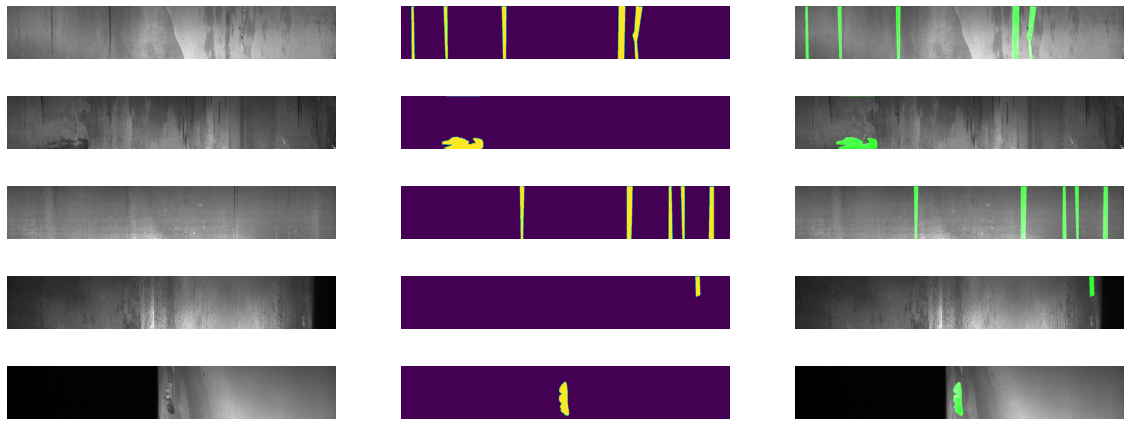

In [35]:
fig,axs = plt.subplots(5,3,figsize=(20,8))
for i in range(5):
    idx = np.random.randint(0,len(defect_class_mask_df))
    mask = rle2mask(defect_class_mask_df.EncodedPixels[idx],H,W)
    img = np.array(Image.open(os.path.join(DATA_PATH,defect_class_mask_df.iloc[idx]["ImageId"])))
    original = img.copy()
    img[mask==1,1] = 255
    axs[i,0].imshow(original)
    axs[i,1].imshow(mask)
    axs[i,2].imshow(img)
    axs[i,0].axis("off")
    axs[i,1].axis("off")
    axs[i,2].axis("off")
    

##  CNN 
CNN katmanları resimden özellik çıkarmada kullanılır. Bizde bir CNN modeli kullanarak sınıflandırma yaptırmaya çalışcağız. CNN modellerinde ilk katmanlar kenar köşe gibi genel özelliklerin çıkartılmasında son katmanlarda daha low level özelliklerin çıkartılmasında kullanılır. Bu örnekte kullanacağımız cnn modeli resnet olacak. 
### RESNET Modeli 
CNN modelleri derinlemesine büyüdüğünde vanishing gradient problemi ile karşılaşırız. Kısaca Vanishing gradient gradientlerin çok düşük değerler alması ve artık weightlerin güncellenmemesi durumudur. Residual Networklerde bir identity mapping kullılır. En genel hali ile identity mapping  inputu bir sonraki katmana gönderirken aynı zamanda inputu daha ilerideki katmanlara da gönderilir bu sayede gönderilen input ileriki katmanlara da taşınmış olur. Bu sayede VG problemi olmadan daha yüksek başarı oranları ile daha derin modelleri geliştirilebilir. 

## Transfer Learning nedir ? 
Bu konuyada önceki yazılarımda bahsettiğim için bunuda en kısa hali ile özetlersek. Belirli bir görev için eğitilmiş modeller daha sonra benzer bir görevi Transfer Learning kullanarak başarabilirler. Burada Resnet modelinin sınıflandırma konusunda ne kadar başarılı bir model olduğunu biliyoruz. Resnet modelinin özellik çıkarmada başarılı olan katmanlarını alıp bunları dondurup en tepesinie kendi taskimin için gerekli olan katmanları ekliyoruz. Bu sayede oldukça başarılı bir sınıflandırma modeli elde etmiş oluyoruz. 

Elimizde bulunan dataframemi train ve test olmak üzere 2 parçaya ayıralım.

In [56]:
train,test = train_test_split(all_images_df,test_size=.15)

In [57]:
train.shape,test.shape

((10682, 2), (1886, 2))

ImageDataGenerator kullanarak dataframede olan verileri train_gen ve validation_gen olarak okuyalım. Resimleri 255'e bölerek scale ettik ve train setinin %15 i validation için ayırdık. 

In [58]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255,validation_split=.15)

train_gen = datagen.flow_from_dataframe(dataframe=train,directory=DATA_PATH,x_col = "ImageId",
                                        y_col="label",subset="training",batch_size=16,shuffle=True,class_mode="other",target_size=(256,256))

validation_gen = datagen.flow_from_dataframe(dataframe=train,directory=DATA_PATH,x_col = "ImageId",
                                        y_col="label",subset="validation",batch_size=16,shuffle=True,class_mode="other",target_size=(256,256))



Found 9080 validated image filenames.
Found 1602 validated image filenames.


Test içinde test setini kullanarak verileri scale edip generator oluşturalım. 

In [59]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(dataframe=test,directory=DATA_PATH,x_col="ImageId",y_col="label",batch_size=16,shuffle=False,class_mode="other",target_size=(256,256))

Found 1886 validated image filenames.


## Sınıflandırma Modelinin oluşturulması 
Yazının başında bahsettiğimiz gibi ResNet modeli kullanacağız. Bu modeli keras kullanarak import edebiliriz. İlgili parametreleri verdikten sonra modelin katmanlarını donduralım.  
Daha sonra resnet modelin en tepesine kendi katmanlarımızı ekleyelim ve modeli oluşturalım. 

In [60]:
basemodel = ResNet50(weights="imagenet",include_top=False,input_tensor=Input(shape=(256,256,3)))

In [61]:
for layer in basemodel.layers:
    layers.trainable = False

In [62]:
# basemodel.summary()

In [63]:
head_model = basemodel.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(256,activation="relu")(head_model)
head_model = Dropout(.3)(head_model)
head_model = Dense(1,activation="sigmoid")(head_model)

model = Model(inputs=basemodel.input,outputs=head_model)

In [64]:
model.compile(loss="binary_crossentropy",optimizer="Nadam",metrics=["accuracy"])

In [65]:
# 20 epochtan sonra val loss düşmüyorsa eğitimi durdur 
early_stoppling = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=20)
# validation loss değerine göre en iyi modeli tut
checkpointer = ModelCheckpoint(filepath="resnet-weights.hdf5",verbose=1,save_best_only=True)

In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch=train_gen.n//16,epochs=40,validation_data=validation_gen,validation_steps=validation_gen.n//16,callbacks=[checkpointer,early_stoppling])

Eğitim uzun süreceği için daha sonra kullanmak üzere modeli ve weightleri save ediyoruz. 

In [36]:
model_json = model.to_json()
with open("models/resnet-classifier.json","w") as json_file:
    json_file.write(model_json)

In [66]:
with open('models/resnet-classifier.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('models/resnet-weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

Modelin basarısını ölçümlemek için test setinde prediction yapalım. Threshold olarak 0.5 değerini belirledim. Bu değerin altında olanlar non-defect bu değerin üzerinde olanları defect olacak şekilde etiketleyelim. 

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_predict = model.predict(test_gen,steps=test_gen.n //16,verbose=1)

117/117 [==============================] - 27s 164ms/step


In [69]:
predicted = [0 if i<0.5 else 1 for i in test_predict]

In [70]:
original = np.asarray(test.label)[:1872]

## Model Başarısının Değerlendirilmesi
accuracy_score,classification_report ve confussion_matrix kullanarak modelin başarısını değerlendirebilir. 

In [71]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original,predicted)
accuracy

0.8162393162393162

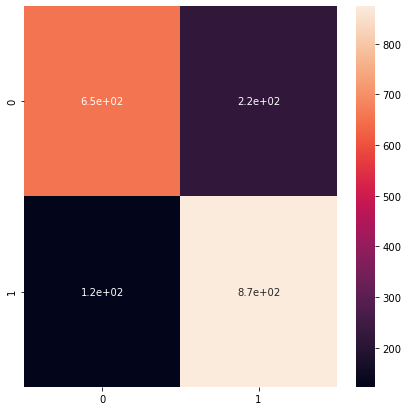

In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original,predicted)
plt.figure(figsize=(7,7))
sns.heatmap(cm,annot=True)

In [73]:
from sklearn.metrics import classification_report
report = classification_report(original,predicted,labels=[0,1])
print(report)

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       875
           1       0.80      0.88      0.84       997

    accuracy                           0.82      1872
   macro avg       0.82      0.81      0.81      1872
weighted avg       0.82      0.82      0.82      1872



## Segementasyon Modelinin Oluşturulması ve Eğitilmesi
### ResUnet Modeli 
UNet modelinin mimarisi ile residual blokların birlikte kullanılması ile oluşturulmuştur. Segmentation tasklarında kullanılmaktadır. Modelin şeklinin U harfine benzemesinden dolayı bu adı almıştır. 
Modelde 3 yapı bulunmaktadır. Bunlar;  
* Encoder   
Her katman inputu alır ve resnet blokları ile decoder modele gönderir. Aynı zamanda Max Pooling ile Downsampling yapılarak bir sonraki katmana gönderilir. 
* Bottleneck   
Encoder ve Decoder arasında bağlantıyı sağlamak için kullanılır. Encoderdan outputu alır ve Upsampling işlemine sokar ve decodera gönderir. 
* Decoder   
Burada encoder modelden aldığı inputlar ve önceki katmandaki inputun upsample edilmiş hali bir birlerine eklenir. Bu sayede resim, input boyutunda segmentasyon işlemi yapılmış hali ile oluşturulur. 



In [85]:
from sklearn.model_selection import train_test_split

x_train,x_test = train_test_split(defect_class_mask_df,test_size=.2)

Train ve test dataları custom data generatore gönderilir ve generatorler oluşturulur. 

In [86]:
train_ids = list(x_train.ImageId)
train_class = list(x_train.ClassId)
train_rle = list(x_train.EncodedPixels)

val_ids = list(x_test.ImageId)
val_class = list(x_test.ClassId)
val_rle = list(x_test.EncodedPixels)

In [87]:
from utilities import DataGenerator

training_gen = DataGenerator(train_ids,train_class,train_rle,DATA_PATH)
validation_gen = DataGenerator(val_ids,val_class,val_rle,DATA_PATH)

Residual blokları sık kullanacağımız için bir fonksiyon olarak tanımlayalım. 

In [88]:
def resblock(X,f):

    # inputun kopyasını oluşturalım
    X_copy = X

    
    X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X) 

    X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)

    # identity
    X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    # outupu ve identity i birbirlerine ekleyelim. 

    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [89]:
# Gönderilen veriyi ve upsample yapılmış inputu birbirine eklemek için 
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])

    return merge

In [90]:
input_shape = (256,256,1)

X_input = Input(input_shape)

#1.adım
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#1.adım
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#2.adım
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#3.adım
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#4.adım
conv5_in = resblock(pool_4, 256)

#Upscale 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


### Custom Loss Fonksiyonu 
Resunet eğitimini yapmak için custom loss fonksiyonu kullanacağız. 

In [91]:
from utilities import focal_tversky,tversky,tversky_loss

In [92]:
adam = tf.keras.optimizers.Adam(lr=0.05,epsilon=0.1)
model_seg.compile(optimizer=adam,loss=focal_tversky,metrics=[tversky])


In [93]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath="models/resunet-segmentation-weights.hdf5", verbose=1, save_best_only=True)

In [166]:
history = model_seg.fit_generator(training_gen, epochs = 40, validation_data= validation_gen, callbacks=[checkpointer, earlystopping])

In [167]:
model_json = model_seg.to_json()
with open("models/resunet-segmentation-model.json","w") as json_file:
      json_file.write(model_json)

In [94]:
from utilities import focal_tversky, tversky_loss, tversky

with open('models/resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model  
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('models/weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

## Test Verisi Üzerinde Sınıflandırma ve Segmentasyon
Modeli test etmek için daha önce görmediği verileri kullanalım. Bunun için test images içerisndeki resimleri glob yardımı ile okuyalım. 

In [97]:
test_images = glob.glob("test_images/*.jpg")

### Sınıflandırma Preprocess ve Predict
İnput resmi sınıflandırma modeline göndermeden önce belirli işlemlerden geçmesi gerekiyor. Bunları yapabilmek için preprocess_and_prediction_cls fonksiyonunu oluşturduk. 

In [98]:
def preprocess_and_prediction_cls(img_path):
    img = np.array(Image.open(img_path))
    img = img * 1./255.
    img = cv2.resize(img,(256,256))
    img = np.array(img,dtype=np.float64)
    img = img.reshape(1,256,256,3)
    prediction = model.predict(img)
    img = img.reshape((256,256,3))
    return prediction,img

### Segmentasyon modeli Preprocess ve Predict
Input resim üzerinde segmentasyon yapmak için de belirli ön işlemlerden geçmesi gerekiyor. Bunun için aşağıdaki fonksiyonu oluşturduk. 

In [99]:
def preprocess_and_prediction_seg(img_path):
    img = np.array(Image.open(img_path))
    img = img[:,:,0]
    X = np.empty((1,256,256,1))    
    img = cv2.resize(img,(256,256))
    img = np.array(img,dtype=np.float64)
    img -= img.mean()
    img /= img.std()
    X[0,] = np.expand_dims(img,axis=2)
    prediction = model_seg.predict(X)
    return prediction,img
    
    

Maskeyi göstermek için find_mask fonksiyonunu oluşturduk. 

In [100]:
def find_masks(pred_seg,img):
    mask = []
    for j in range(4):

        mask_value = pred_seg[0,:,:,j].round().astype(int)

        if mask_value.sum() > 0.5:
            try:
                img[mask_value == 1] = 255
                img = cv2.resize(img,(1600,256))
                img[img < 255] = 0
                img = img * 1./255.
                rle = mask2rle(img)

            except:
                print("xx")
                continue

            mask.append(rle)
    return mask

Aşağıdaki test resimleri içerisinde okunan 20 resim üzerinde önce sınıflandırma daha sonra segmentasyon işlemi yapılmış halini görüyorsunuz

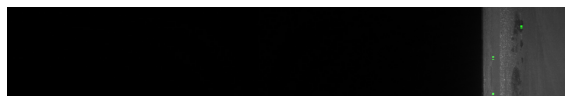

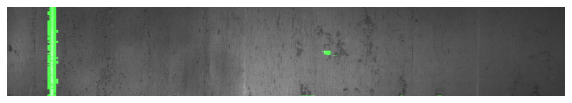

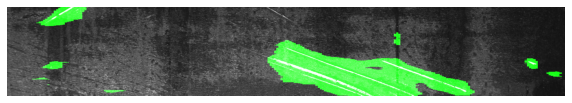

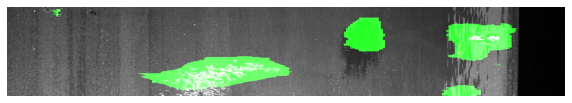

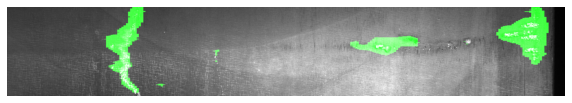

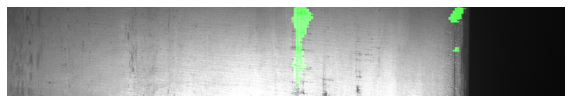

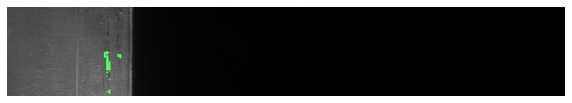

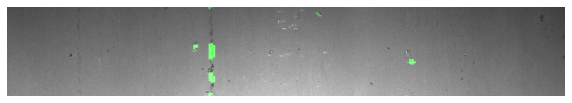

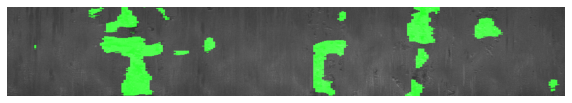

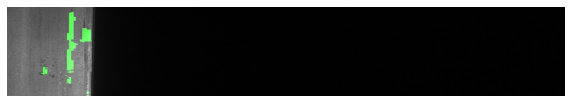

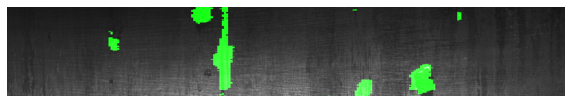

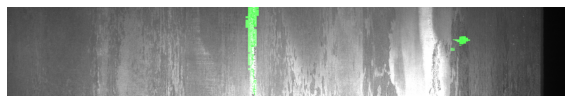

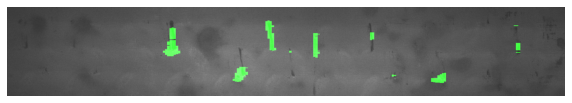

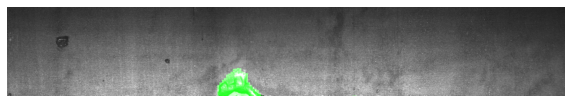

In [101]:
for img_path in test_images[0:20]:
    pred_cls,img = preprocess_and_prediction_cls(img_path)
    if pred_cls<0.5:
        continue
    pred_seg,img = preprocess_and_prediction_seg(img_path)
    mask = find_masks(pred_seg,img)
    img = np.array(Image.open(img_path))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    mask = rle2mask(mask[0],H,W)
    img[mask ==1,1] = 255
    plt.figure(figsize=(10,5))
    plt.imshow(img)
    plt.axis("off")